## Import Required Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

## Set Device

In [2]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using Apple MPS (Metal Performance Shaders)")
# else:
device = torch.device("cpu")
print("Using CPU")

Using CPU


## Data Preprocessing and Transforms

In [3]:
# Define the transformations for training and testing

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize to slightly larger
    transforms.RandomCrop(224),                       # Random crop for augmentation
    transforms.RandomHorizontalFlip(),                # Flip left-right (not up-down)
    transforms.Grayscale(num_output_channels=1),      # Ensure grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),                    # Direct resize to 224x224
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the dataset

train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(val_dir, transform=transform_test)
test_data = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

## Visualize Data

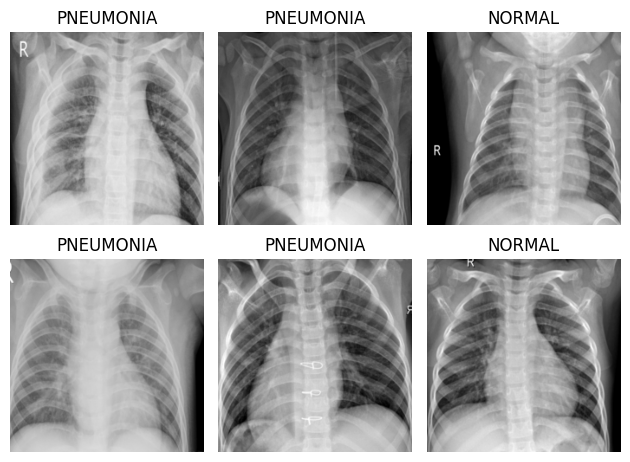

In [4]:
# Display a batch of images from the training set

classes = train_data.classes
def show_batch():
    images, labels = next(iter(train_loader))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        img = images[i].squeeze()  # [224, 224]
        plt.imshow(img, cmap='gray')
        plt.title(classes[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_batch()


## Define CNN Model

In [5]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.features = nn.Sequential(

            # Block 1

            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),  # adjust depending on your image input size
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)  # binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = PneumoniaCNN().to(device)

## Loss, Optimizer

In [6]:
normal_count = 1341 # Number of normal images in the training set
pneumonia_count = 3875 # Number of pneumonia images in the training set

# Calculate the positive weight for the loss function

pos_weight = torch.tensor([normal_count / pneumonia_count]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [7]:
epochs = 4
for epoch in range(epochs):

    # ----- Training Phase -----
    
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # ----- Accuracy Calculation -----

        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total

    # ----- Validation Phase -----

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # ----- Logging -----
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

Epoch 1/4, Train Loss: 0.6027, Train Acc: 0.8413, Val Loss: 0.4630
Epoch 2/4, Train Loss: 0.0907, Train Acc: 0.9204, Val Loss: 1.3294
Epoch 3/4, Train Loss: 0.0812, Train Acc: 0.9210, Val Loss: 0.4917
Epoch 4/4, Train Loss: 0.0774, Train Acc: 0.9325, Val Loss: 0.2333


## Evaluation

In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs >= 0.6).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=classes))


[[201  33]
 [ 56 334]]
              precision    recall  f1-score   support

      NORMAL       0.78      0.86      0.82       234
   PNEUMONIA       0.91      0.86      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.86      0.86      0.86       624



## Saving the model

In [9]:
os.makedirs("backend/saved_models", exist_ok=True)

torch.save(model.state_dict(), "backend/saved_models/pneumonia_cnn.pth")
print("Model saved successfully at backend/saved_models/pneumonia_cnn.pth")

Model saved successfully at backend/saved_models/pneumonia_cnn.pth
